In [1]:
import sys
sys.path.insert(0,"/home/albert7a/lib/python")


## imports

import numpy as np
import dask
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
import time
from dask.diagnostics import ProgressBar
from datetime import date
import yaml
import io
import json
import cmocean
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

%matplotlib inline

/home/albert/anaconda2/lib/python2.7/site-packages/matplotlib/ticker.py:1685: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


In [122]:
def select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax):
        ''' Identify all the EN4 profiles that fall within the selected zone and period
        '''
        ## Datasets

        #EN4
        diren4="/media/extra/DATA/EN4/"

        yearmin=datemin[0:4]
        monthmin=datemin[5:7]
        yearmax=datemax[0:4]
        monthmax=datemax[5:7]

        list_filesEN4=[]
        if yearmin == yearmax:
            for m in np.arange(int(monthmin),int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
        else:
            for m in np.arange(int(monthmin),13):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
            for m in np.arange(1,int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+str(m)+'.nc')

        datetmin=pd.to_datetime(datemin)
        datetmax=pd.to_datetime(datemax)
        ttmin=datetime.datetime(int(datetmin.strftime('%Y')),int(datetmin.strftime('%m')),int(datetmin.strftime('%d')),int(datetmin.strftime('%H')),int(datetmin.strftime('%M')))
        ttmax=datetime.datetime(int(datetmax.strftime('%Y')),int(datetmax.strftime('%m')),int(datetmax.strftime('%d')),int(datetmax.strftime('%H')),int(datetmax.strftime('%M')))
        tsecmin=(ttmin-datetime.datetime(1958,1,1,0,0)).total_seconds()
        tsecmax=(ttmax-datetime.datetime(1958,1,1,0,0)).total_seconds()
        nb_profiles=0.
        for f in np.arange(len(list_filesEN4)):
                fileEN4=list_filesEN4[f]
                tfileEN4=diren4+fileEN4

                dsen4=xr.open_dataset(tfileEN4)
                laten4=dsen4['LATITUDE']
                lonen4=dsen4['LONGITUDE']
                dayen4=dsen4['JULD']
                refen4=dsen4['DC_REFERENCE']

                indz=np.where((lonmin<=lonen4.values)&(lonen4.values<lonmax)&(latmin<=laten4.values)&(laten4.values<latmax))
                prof_zone=[]
                tsecen4z=[]
                for ref in np.arange(len(indz[0])):
                    dateen4= pd.to_datetime(str(dayen4[indz[0][ref]].values))
                    ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
                    tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()
                    if (tsecen4 < tsecmax) & (tsecen4 > tsecmin):
                        prof_zone.append(indz[0][ref])
                        tsecen4z.append(tsecen4)

                nb_profiles=nb_profiles+len(prof_zone)
        return nb_profiles


In [123]:
latmin,latmax,lonmin,lonmax = 27,60,-80,8
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nb_profiles_NATL60_1year=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nb_profiles_NATL60_1year


90544.0


In [124]:
#quadrillage tous les 0.5°

Xbox=(lonmax-lonmin+1)/0.5
Ybox=(latmax-latmin+1)/0.5

nb_prof_box05_1year=np.zeros((Xbox,Ybox,3))

for i in np.arange(Xbox):
    for j in np.arange(Ybox):
        lat1=latmin+0.5*j
        lat2=latmin+0.5*(j+1.)
        lon1=lonmin+0.5*i
        lon2=lonmin+0.5*(i+1.)
        nb=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
        nb_prof_box05_1year[i,j,0]=nb
        nb_prof_box05_1year[i,j,1]=0.5*(lat2+lat1)
        nb_prof_box05_1year[i,j,2]=0.5*(lon1+lon2)


/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [125]:
nb_prof_box05_1year.shape

(178, 68, 3)

In [126]:
np.nanmax(nb_prof_box05_1year[:,:,0])

4538.0

In [63]:
nb_prof_box05_1year[:,:,0]

array([[  2.,   0.,   0., ...,   0.,   0.,   0.],
       [  9.,  12.,   0., ...,   0.,   0.,   0.],
       [  2.,  33.,   1., ...,   0.,   0.,   0.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [64]:
print nb_prof_box05_1year[0,0,0]

2.0


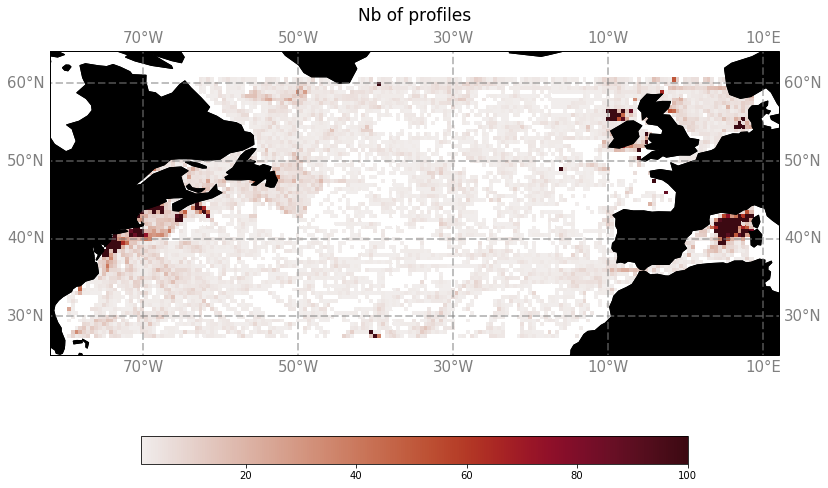

In [127]:
fig = plt.figure(figsize=(15,10))  # (w,h)
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-30))
ax.set_extent([-82, 12, 25, 55])
cmap=cmocean.cm.amp
cmap.set_under(color='white')
pcolor=ax.pcolormesh(nb_prof_box05_1year[:,:,2], nb_prof_box05_1year[:,:,1],nb_prof_box05_1year[:,:,0],transform=ccrs.PlateCarree(),cmap=cmap,vmin=1,vmax=100)
ax.add_feature(cfeature.LAND,facecolor='black')
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=2, color='grey', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
gl.xlocator = mticker.FixedLocator([-110,-90,-70,-50,-30,-10,10,30,50,70,90,110])
gl.ylocator = mticker.FixedLocator([-10,0,10,20,30,40,50,60,70,80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75)

ax.set_title('Nb of profiles',size=17,y=1.08)
plt.savefig("nb_profiles_decoupage025.png")

In [25]:
idgrand=np.where(nb_prof_box05_1year[:,:,0]>200)

In [26]:
idgrand[0].shape

(68,)

In [27]:
idgrand[1].shape

(68,)

In [28]:
nb_prof_box05_1year[idgrand[0][:],idgrand[1][:],0]

array([ 1501.,  1188.,   424.,  1360.,  1043.,   353.,  1452.,   464.,
         263.,   381.,   563.,   658.,   249.,   219.,   333.,   246.,
         275.,   233.,  4192.,   215.,  4294.,   240.,  4206.,  4538.,
        2942.,  4255.,   236.,   900.,   631.,   345.,  2171.,  1931.,
         388.,   218.,   632.,   430.,   268.,   277.,   324.,   274.,
         519.,   461.,   206.,   231.,   285.,   578.,   320.,   377.,
         365.,   673.,   421.,   229.,   305.,   364.,   226.,   242.,
         286.,   527.,   278.,   546.,   251.,   257.,   683.,   419.,
         370.,   302.,   902.,   220.])

In [18]:
id101=np.where(nb_prof_box05_1year[:,:,0]==101)

In [20]:
print id101[0][0], id101[1][0]

152 58


In [21]:
nb_prof_box05_1year[152,58,0]

101.0

In [22]:
nb_prof_box05_1year[152,58,1]

56.25

In [23]:
nb_prof_box05_1year[152,58,2]

-3.75

In [24]:
latmin,latmax,lonmin,lonmax = 56,56.5,-4,-3.5
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nb101=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nb101


101.0


In [29]:
id206=np.where(nb_prof_box05_1year[:,:,0]==206)
print id206[0][0], id206[1][0]
print "nb", nb_prof_box05_1year[id206[0][0], id206[1][0],0]
print "lat", nb_prof_box05_1year[id206[0][0], id206[1][0],1]
print "lon", nb_prof_box05_1year[id206[0][0], id206[1][0],2]

169 25
nb 206.0
lat 39.75
lon 4.75


In [31]:
latmin,latmax,lonmin,lonmax = 39.5,40,4.5,5
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nb206=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nb206



206.0


In [32]:
idgrand=np.where(nb_prof_box05_1year[:,:,0]>500)

In [33]:
nb_prof_box05_1year[idgrand[0][:],idgrand[1][:],0]

array([ 1501.,  1188.,  1360.,  1043.,  1452.,   563.,   658.,  4192.,
        4294.,  4206.,  4538.,  2942.,  4255.,   900.,   631.,  2171.,
        1931.,   632.,   519.,   578.,   673.,   527.,   546.,   683.,
         902.])

In [34]:
id519=np.where(nb_prof_box05_1year[:,:,0]==519)
print id519[0][0], id519[1][0]
print "nb", nb_prof_box05_1year[id519[0][0], id519[1][0],0]
print "lat", nb_prof_box05_1year[id519[0][0], id519[1][0],1]
print "lon", nb_prof_box05_1year[id519[0][0], id519[1][0],2]

168 28
nb 519.0
lat 41.25
lon 4.25


In [35]:
latmin,latmax,lonmin,lonmax = 41,41.5,4,4.5
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nb519=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nb519


519.0


In [36]:
id1043=np.where(nb_prof_box05_1year[:,:,0]==1043)
print id1043[0][0], id1043[1][0]
print "nb", nb_prof_box05_1year[id1043[0][0], id1043[1][0],0]
print "lat", nb_prof_box05_1year[id1043[0][0], id1043[1][0],1]
print "lon", nb_prof_box05_1year[id1043[0][0], id1043[1][0],2]

10 23
nb 1043.0
lat 38.75
lon -74.75


In [37]:
latmin,latmax,lonmin,lonmax = 38.5,39,-75,-74.5
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nb1043=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nb1043

1043.0


In [38]:
idmax=np.where(nb_prof_box05_1year[:,:,0]==np.nanmax(nb_prof_box05_1year[:,:,0]))

In [39]:
print idmax[0][0], idmax[1][0]
print "nb", nb_prof_box05_1year[idmax[0][0], idmax[1][0],0]
print "lat", nb_prof_box05_1year[idmax[0][0], idmax[1][0],1]
print "lon", nb_prof_box05_1year[idmax[0][0], idmax[1][0],2]

23 34
nb 4538.0
lat 44.25
lon -68.25


In [40]:
latmin,latmax,lonmin,lonmax = 44,44.5,-68.5,-68
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nbmax

4538.0


In [41]:
nb_prof_box05_1year.shape

(178, 68, 3)

In [42]:
idnonzeros=np.where(nb_prof_box05_1year[:,:,0]>0)

In [43]:
idnonzeros[0].shape

(6401,)

In [44]:
idmille=np.where(nb_prof_box05_1year[:,:,0]>1000)

In [45]:
idmille[0].shape

(13,)

In [128]:
idcent=np.where(nb_prof_box05_1year[:,:,0]>100)
idcent[0].shape

(103,)

In [129]:
def list_reference_profiles(list_reference,latmin,latmax,lonmin,lonmax,datemin,datemax):
        ''' Identify all the EN4 profiles that fall within the selected zone and period
        '''
        ## Datasets

        #EN4
        diren4="/media/extra/DATA/EN4/"

        yearmin=datemin[0:4]
        monthmin=datemin[5:7]
        yearmax=datemax[0:4]
        monthmax=datemax[5:7]

        list_filesEN4=[]
        if yearmin == yearmax:
            for m in np.arange(int(monthmin),int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
        else:
            for m in np.arange(int(monthmin),13):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
            for m in np.arange(1,int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+str(m)+'.nc')

        datetmin=pd.to_datetime(datemin)
        datetmax=pd.to_datetime(datemax)
        ttmin=datetime.datetime(int(datetmin.strftime('%Y')),int(datetmin.strftime('%m')),int(datetmin.strftime('%d')),int(datetmin.strftime('%H')),int(datetmin.strftime('%M')))
        ttmax=datetime.datetime(int(datetmax.strftime('%Y')),int(datetmax.strftime('%m')),int(datetmax.strftime('%d')),int(datetmax.strftime('%H')),int(datetmax.strftime('%M')))
        tsecmin=(ttmin-datetime.datetime(1958,1,1,0,0)).total_seconds()
        tsecmax=(ttmax-datetime.datetime(1958,1,1,0,0)).total_seconds()
        nb_profiles=0.
        
        for f in np.arange(len(list_filesEN4)):
                fileEN4=list_filesEN4[f]
                tfileEN4=diren4+fileEN4

                dsen4=xr.open_dataset(tfileEN4)
                laten4=dsen4['LATITUDE']
                lonen4=dsen4['LONGITUDE']
                dayen4=dsen4['JULD']
                refen4=dsen4['DC_REFERENCE']

                indz=np.where((lonmin<lonen4.values)&(lonen4.values<lonmax)&(latmin<laten4.values)&(laten4.values<latmax))

                prof_zone=[]
                tsecen4z=[]

                for ref in np.arange(len(indz[0])):
                        dateen4= pd.to_datetime(str(dayen4[indz[0][ref]].values))
                        ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
                        tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()
                        if (tsecen4 < tsecmax) & (tsecen4 > tsecmin):
                                prof_zone.append(indz[0][ref])
                                tsecen4z.append(tsecen4)

                for ref in np.arange(len(prof_zone)):
                        list_reference.append(str(refen4[prof_zone[ref]].values))


        return list_reference


In [53]:
latmin,latmax,lonmin,lonmax = 44,44.5,-68.5,-68
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

list_reference=[]
list_reference=list_reference_profiles(list_reference,latmin,latmax,lonmin,lonmax,datemin,datemax)


In [54]:
len(list_reference)

4537

In [55]:
print idcent[0][0], idcent[1][0]
print "nb", nb_prof_box05_1year[idcent[0][0], idcent[1][0],0]
print "lat", nb_prof_box05_1year[idcent[0][0], idcent[1][0],1]
print "lon", nb_prof_box05_1year[idcent[0][0], idcent[1][0],2]

9 21
nb 1501.0
lat 37.75
lon -75.25


In [56]:
list_reference=[]


latmin,latmax,lonmin,lonmax = 44,44.5,-68.5,-68
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'
list_reference=list_reference_profiles(list_reference,latmin,latmax,lonmin,lonmax,datemin,datemax)

latmin,latmax,lonmin,lonmax = 37.5,38,-75.5,-75
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'
list_reference=list_reference_profiles(list_reference,latmin,latmax,lonmin,lonmax,datemin,datemax)


In [57]:
len(list_reference)

6038

In [130]:
list_reference=[]

for k in np.arange(len(idcent[0])):
    latmin=nb_prof_box05_1year[idcent[0][k], idcent[1][k],1]-0.25
    latmax=nb_prof_box05_1year[idcent[0][k], idcent[1][k],1]+0.25
    lonmin=nb_prof_box05_1year[idcent[0][k], idcent[1][k],2]-0.25
    lonmax=nb_prof_box05_1year[idcent[0][k], idcent[1][k],2]+0.25
    datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'
    list_reference=list_reference_profiles(list_reference,latmin,latmax,lonmin,lonmax,datemin,datemax)


In [131]:
len(list_reference)

60829

In [132]:
def select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference):
        ''' Identify all the EN4 profiles that fall within the selected zone and period
        '''
        ## Datasets

        #EN4
        diren4="/media/extra/DATA/EN4/"

        yearmin=datemin[0:4]
        monthmin=datemin[5:7]
        yearmax=datemax[0:4]
        monthmax=datemax[5:7]

        list_filesEN4=[]
        if yearmin == yearmax:
            for m in np.arange(int(monthmin),int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
        else:
            for m in np.arange(int(monthmin),13):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
            for m in np.arange(1,int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+str(m)+'.nc')

        datetmin=pd.to_datetime(datemin)
        datetmax=pd.to_datetime(datemax)
        ttmin=datetime.datetime(int(datetmin.strftime('%Y')),int(datetmin.strftime('%m')),int(datetmin.strftime('%d')),int(datetmin.strftime('%H')),int(datetmin.strftime('%M')))
        ttmax=datetime.datetime(int(datetmax.strftime('%Y')),int(datetmax.strftime('%m')),int(datetmax.strftime('%d')),int(datetmax.strftime('%H')),int(datetmax.strftime('%M')))
        tsecmin=(ttmin-datetime.datetime(1958,1,1,0,0)).total_seconds()
        tsecmax=(ttmax-datetime.datetime(1958,1,1,0,0)).total_seconds()
        nb_profiles=0.
        for f in np.arange(len(list_filesEN4)):
                fileEN4=list_filesEN4[f]
                tfileEN4=diren4+fileEN4

                dsen4=xr.open_dataset(tfileEN4)
                laten4=dsen4['LATITUDE']
                lonen4=dsen4['LONGITUDE']
                dayen4=dsen4['JULD']
                refen4=dsen4['DC_REFERENCE']

                indz=np.where((lonmin<=lonen4.values)&(lonen4.values<lonmax)&(latmin<=laten4.values)&(laten4.values<latmax))
                prof_zone=[]
                tsecen4z=[]
                
                for ref in np.arange(len(indz[0])):
                        dateen4= pd.to_datetime(str(dayen4[indz[0][ref]].values))
                        ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
                        tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()
                        if (tsecen4 < tsecmax) & (tsecen4 > tsecmin):
                                prof_zone.append(indz[0][ref])
                                tsecen4z.append(tsecen4)

                list_ref=[]
                for ref in np.arange(len(prof_zone)):
                        if not str(refen4[prof_zone[ref]].values) in list_reference:
                            list_ref.append(ref)

                nb_profiles=nb_profiles+len(list_ref)
        return nb_profiles


In [61]:
latmin,latmax,lonmin,lonmax = 37.5,38,-75.5,-75
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'
nb_profiles=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)

In [62]:
print nb_profiles

0.0


In [65]:
print nb_prof_box05_1year[0,0,1]
print nb_prof_box05_1year[0,0,2]


27.25
-79.75


In [66]:
latmin,latmax,lonmin,lonmax = 27,27.5,-80,-79.5
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'
nb_profiles=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)

In [67]:
print nb_profiles

2.0


In [133]:
#quadrillage tous les 1°
latmin,latmax,lonmin,lonmax = 27,60,-80,8
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

Xbox=(lonmax-lonmin+1)
Ybox=(latmax-latmin+1)

nb_prof_box1_1year=np.zeros((Xbox,Ybox,3))

for i in np.arange(Xbox):
    for j in np.arange(Ybox):
        lat1=latmin+j
        lat2=latmin+(j+1.)
        lon1=lonmin+i
        lon2=lonmin+(i+1.)
        nb=select_profiles_noreference(lat1,lat2,lon1,lon2,datemin,datemax,list_reference)
        nb_prof_box1_1year[i,j,0]=nb
        nb_prof_box1_1year[i,j,1]=0.5*(lat2+lat1)
        nb_prof_box1_1year[i,j,2]=0.5*(lon1+lon2)


In [134]:
nb_prof_box1_1year.shape

(89, 34, 3)

In [70]:
print nb_prof_box1_1year[:,:,0]

[[ 23.   0.   3. ...,   0.   0.   0.]
 [ 59.  10.   1. ...,   0.   0.   0.]
 [ 31.  32.   7. ...,   0.   0.   0.]
 ..., 
 [  0.   0.   0. ...,  12.   2.  82.]
 [  0.   0.   0. ...,   1.   0.   8.]
 [  0.   0.   0. ...,  80.   0.   0.]]


In [135]:
print np.nanmax(nb_prof_box1_1year[:,:,0])
idmax=np.where(nb_prof_box1_1year[:,:,0]==np.nanmax(nb_prof_box1_1year[:,:,0]))
print nb_prof_box1_1year[idmax[0][0],idmax[1][0],1]
print nb_prof_box1_1year[idmax[0][0],idmax[1][0],2]

4279.0
44.5
-68.5


In [77]:
latmin=55
latmax=56
lonmin=-9
lonmax=-8
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nbmax
nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print nbmax

332.0
193.0


In [136]:
idcent=np.where(nb_prof_box1_1year[:,:,0]>100)
print len(idcent[0]),' boxes'
#for k in np.arange(len(idcent[0])):
#    print nb_prof_box1_1year[idcent[0][k],idcent[1][k],0],' profiles'
#    print 'lat = ',nb_prof_box1_1year[idcent[0][k],idcent[1][k],1]
#    print 'lon = ',nb_prof_box1_1year[idcent[0][k],idcent[1][k],2]


21  boxes


In [137]:
id1=np.where(nb_prof_box1_1year[:,:,0]>50)
print len(idcent[0]),' boxes with more than 50 profiles'
#for k in np.arange(len(idcent[0])):
#    print nb_prof_box1_1year[idcent[0][k],idcent[1][k],0],' profiles'
#    print 'lat = ',nb_prof_box1_1year[idcent[0][k],idcent[1][k],1]
#    print 'lon = ',nb_prof_box1_1year[idcent[0][k],idcent[1][k],2]


21  boxes with more than 50 profiles


In [85]:
def append_list_reference_profiles(list_reference,latmin,latmax,lonmin,lonmax,datemin,datemax):
        ''' Identify all the EN4 profiles that fall within the selected zone and period
        '''
        ## Datasets

        #EN4
        diren4="/media/extra/DATA/EN4/"

        yearmin=datemin[0:4]
        monthmin=datemin[5:7]
        yearmax=datemax[0:4]
        monthmax=datemax[5:7]

        list_filesEN4=[]
        if yearmin == yearmax:
            for m in np.arange(int(monthmin),int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
        else:
            for m in np.arange(int(monthmin),13):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
            for m in np.arange(1,int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+str(m)+'.nc')

        datetmin=pd.to_datetime(datemin)
        datetmax=pd.to_datetime(datemax)
        ttmin=datetime.datetime(int(datetmin.strftime('%Y')),int(datetmin.strftime('%m')),int(datetmin.strftime('%d')),int(datetmin.strftime('%H')),int(datetmin.strftime('%M')))
        ttmax=datetime.datetime(int(datetmax.strftime('%Y')),int(datetmax.strftime('%m')),int(datetmax.strftime('%d')),int(datetmax.strftime('%H')),int(datetmax.strftime('%M')))
        tsecmin=(ttmin-datetime.datetime(1958,1,1,0,0)).total_seconds()
        tsecmax=(ttmax-datetime.datetime(1958,1,1,0,0)).total_seconds()
        nb_profiles=0.
        
        for f in np.arange(len(list_filesEN4)):
                fileEN4=list_filesEN4[f]
                tfileEN4=diren4+fileEN4

                dsen4=xr.open_dataset(tfileEN4)
                laten4=dsen4['LATITUDE']
                lonen4=dsen4['LONGITUDE']
                dayen4=dsen4['JULD']
                refen4=dsen4['DC_REFERENCE']

                indz=np.where((lonmin<lonen4.values)&(lonen4.values<lonmax)&(latmin<laten4.values)&(laten4.values<latmax))

                prof_zone=[]
                tsecen4z=[]

                for ref in np.arange(len(indz[0])):
                        dateen4= pd.to_datetime(str(dayen4[indz[0][ref]].values))
                        ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
                        tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()
                        if (tsecen4 < tsecmax) & (tsecen4 > tsecmin):
                            if not str(refen4[indz[0][ref]].values) in list_reference:
                                prof_zone.append(indz[0][ref])
                                tsecen4z.append(tsecen4)

                for ref in np.arange(len(prof_zone)):
                        list_reference.append(str(refen4[prof_zone[ref]].values))


        return list_reference


In [86]:
#list_reference=[]
#append existing list_reference

for k in np.arange(len(id1[0])):
    latmin=nb_prof_box1_1year[id1[0][k], id1[1][k],1]-0.5
    latmax=nb_prof_box1_1year[id1[0][k], id1[1][k],1]+0.5
    lonmin=nb_prof_box1_1year[id1[0][k], id1[1][k],2]-0.5
    lonmax=nb_prof_box1_1year[id1[0][k], id1[1][k],2]+0.5
    datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'
    list_reference=append_list_reference_profiles(list_reference,latmin,latmax,lonmin,lonmax,datemin,datemax)


In [88]:
len(list_reference)

66085

In [92]:
#quadrillage tous les 5°
latmin,latmax,lonmin,lonmax = 27,60,-80,8
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

Xbox=(lonmax-lonmin+1)/5
Ybox=(latmax-latmin+1)/5

nb_prof_box5_1year=np.zeros((Xbox,Ybox,3))

for i in np.arange(Xbox):
    for j in np.arange(Ybox):
        lat1=latmin+5*j
        lat2=latmin+5*(j+1.)
        lon1=lonmin+5*i
        lon2=lonmin+5*(i+1.)
        nb=select_profiles_noreference(lat1,lat2,lon1,lon2,datemin,datemax,list_reference)
        nb_prof_box5_1year[i,j,0]=nb
        nb_prof_box5_1year[i,j,1]=0.5*(lat2+lat1)
        nb_prof_box5_1year[i,j,2]=0.5*(lon1+lon2)


In [93]:
nb_prof_box5_1year.shape

(17, 6, 3)

In [94]:
17*6

102

In [95]:
print np.nanmax(nb_prof_box5_1year[:,:,0])

4873.0


In [106]:
print np.nanmax(nb_prof_box5_1year[:,:,0])
idmax=np.where(nb_prof_box5_1year[:,:,0]==np.nanmax(nb_prof_box5_1year[:,:,0]))

print 'lat =',nb_prof_box5_1year[idmax[0][0],idmax[1][0],1]
print 'lon =',nb_prof_box5_1year[idmax[0][0],idmax[1][0],2]


4873.0
lat = 44.5
lon = -67.5


In [107]:
latmin=43
latmax=47
lonmin=-70
lonmax=-65
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nbmax
nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print nbmax

17026.0
4594.0


In [97]:

idmax=np.where(nb_prof_box5_1year[:,:,0]==np.nanmax(nb_prof_box5_1year[:,:,0]))
print nb_prof_box5_1year[idmax[0][0],idmax[1][0],1]
print nb_prof_box5_1year[idmax[0][0],idmax[1][0],2]

44.5
-67.5


In [98]:
#quadrillage tous les 2°
latmin,latmax,lonmin,lonmax = 27,60,-80,8
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

Xbox=(lonmax-lonmin+1)/2
Ybox=(latmax-latmin+1)/2

nb_prof_box2_1year=np.zeros((Xbox,Ybox,3))

for i in np.arange(Xbox):
    for j in np.arange(Ybox):
        lat1=latmin+2*j
        lat2=latmin+2*(j+1.)
        lon1=lonmin+2*i
        lon2=lonmin+2*(i+1.)
        nb=select_profiles_noreference(lat1,lat2,lon1,lon2,datemin,datemax,list_reference)
        nb_prof_box2_1year[i,j,0]=nb
        nb_prof_box2_1year[i,j,1]=0.5*(lat2+lat1)
        nb_prof_box2_1year[i,j,2]=0.5*(lon1+lon2)


In [104]:
print np.nanmax(nb_prof_box2_1year[:,:,0])
idmax=np.where(nb_prof_box2_1year[:,:,0]==np.nanmax(nb_prof_box2_1year[:,:,0]))

print 'lat =',nb_prof_box2_1year[idmax[0][0],idmax[1][0],1]
print 'lon =',nb_prof_box2_1year[idmax[0][0],idmax[1][0],2]


4331.0
lat = 44.0
lon = -69.0


In [105]:
latmin=43
latmax=45
lonmin=-70
lonmax=-68
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nbmax
nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print nbmax

13821.0
4331.0


In [108]:
latmin=43
latmax=44
lonmin=-70
lonmax=-69
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print '1er quart =',nbmax

latmin=43
latmax=44
lonmin=-69
lonmax=-68
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print '2e quart =',nbmax

latmin=44
latmax=45
lonmin=-70
lonmax=-69
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print '3e quart =',nbmax

latmin=44
latmax=45
lonmin=-69
lonmax=-68
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print '4e quart =',nbmax

1er quart = 29.0
2e quart = 22.0
3e quart = 0.0
4e quart = 0.0


In [112]:

latmin=43.5
latmax=44.5
lonmin=-69.5
lonmax=-68.5
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nbmax
nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print nbmax

8636.0
4278.0


In [111]:
latmin=43.75
latmax=44.25
lonmin=-69.25
lonmax=-68.75
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

nbmax=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nbmax
nbmax=select_profiles_noreference(latmin,latmax,lonmin,lonmax,datemin,datemax,list_reference)
print nbmax


4299.0
4278.0


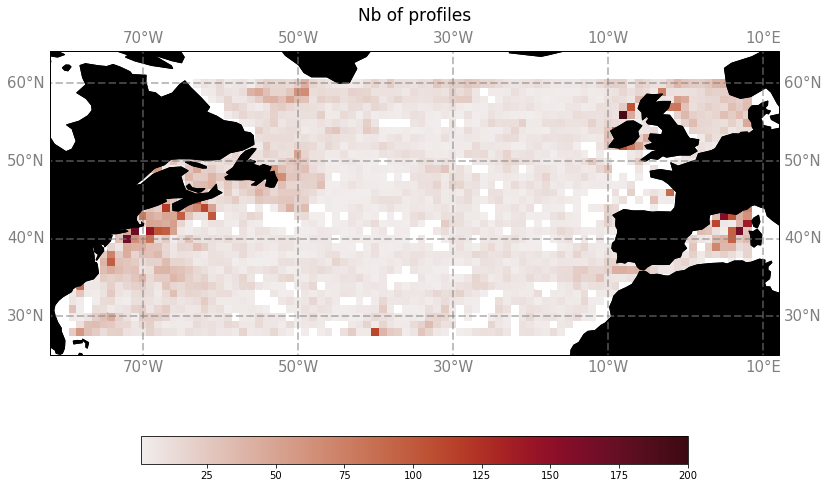

In [101]:
fig = plt.figure(figsize=(15,10))  # (w,h)
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-30))
ax.set_extent([-82, 12, 25, 55])
cmap=cmocean.cm.amp
cmap.set_under(color='white')
pcolor=ax.pcolormesh(nb_prof_box1_1year[:,:,2], nb_prof_box1_1year[:,:,1],nb_prof_box1_1year[:,:,0],transform=ccrs.PlateCarree(),cmap=cmap,vmin=1,vmax=200)
ax.add_feature(cfeature.LAND,facecolor='black')
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=2, color='grey', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
gl.xlocator = mticker.FixedLocator([-110,-90,-70,-50,-30,-10,10,30,50,70,90,110])
gl.ylocator = mticker.FixedLocator([-10,0,10,20,30,40,50,60,70,80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75)

ax.set_title('Nb of profiles',size=17,y=1.08)
plt.savefig("nb_profiles_decoupage1.png")

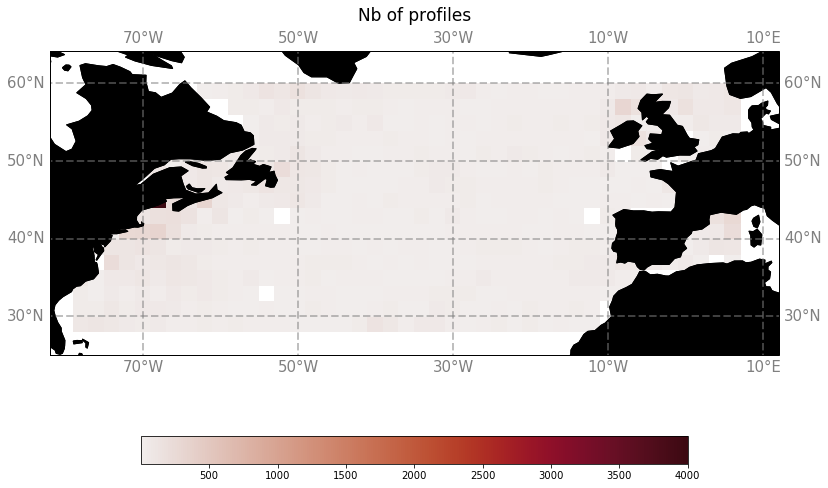

In [103]:
fig = plt.figure(figsize=(15,10))  # (w,h)
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-30))
ax.set_extent([-82, 12, 25, 55])
cmap=cmocean.cm.amp
cmap.set_under(color='white')
pcolor=ax.pcolormesh(nb_prof_box2_1year[:,:,2], nb_prof_box2_1year[:,:,1],nb_prof_box2_1year[:,:,0],transform=ccrs.PlateCarree(),cmap=cmap,vmin=1,vmax=4000)
ax.add_feature(cfeature.LAND,facecolor='black')
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=2, color='grey', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
gl.xlocator = mticker.FixedLocator([-110,-90,-70,-50,-30,-10,10,30,50,70,90,110])
gl.ylocator = mticker.FixedLocator([-10,0,10,20,30,40,50,60,70,80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75)

ax.set_title('Nb of profiles',size=17,y=1.08)
plt.savefig("nb_profiles_decoupage2.png")